In [1]:
# !unzip -q /content/en-ner-conll-2003.zip -d /content/

In [ ]:
!pip uninstall torch
!pip install torch

In [5]:
!pip install transformers

In [6]:
import os
import pandas as pd
import gensim
from gensim.models import KeyedVectors
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.regularizers import l2
from collections import Counter
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
[WinError 126] Nie można odnaleźć określonego modułu. Error loading "C:\Users\Pawel\AppData\Roaming\Python\Python311\site-packages\torch\lib\shm.dll" or one of its dependencies.

### Declare path

In [3]:
data_dir_path = 'en-ner-conll-2003'
train_path = os.path.join(data_dir_path, 'train', 'train.tsv')
dev_texts_path = os.path.join(data_dir_path, 'dev-0', 'in.tsv')
dev_labels_path = os.path.join(data_dir_path, 'dev-0', 'expected.tsv')
dev_predicted_path = os.path.join(data_dir_path, 'dev-0', 'out.tsv')
test_texts_path = os.path.join(data_dir_path, 'test-A', 'in.tsv')
test_predicted_path = os.path.join(data_dir_path, 'test-A', 'out.tsv')
word2vec_file_path = 'word2vec_100_3_polish.bin'

### Load files

In [4]:
train_data = pd.read_csv(train_path, sep='\t', usecols=[0, 1], header=None, names=['label', 'text'])
dev_texts_data = pd.read_csv(dev_texts_path, sep='\t', usecols=[0], header=None, names=['text'])
dev_labels_data = pd.read_csv(dev_labels_path, sep='\t', usecols=[0], header=None, names=['label'])
test_texts_data = pd.read_csv(test_texts_path, sep='\t', usecols=[0], header=None, names=['text'])

### Do transformer

In [1]:
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
recognizer = pipeline("ner", model=model, tokenizer=tokenizer)

NameError: name 'AutoModelForTokenClassification' is not defined

### Build Vocab

In [5]:
def build_vocab(dataset):
    counter = Counter()
    for document in dataset:
        counter.update(document)
    return vocab(counter, specials=["<unk>", "<pad>", "<bos>", "<eos>"])

In [6]:
train_X = train_data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
v = build_vocab(train_X)

In [7]:
itos = v.get_itos()

In [8]:
print(itos)

['<unk>', '<pad>', '<bos>', '<eos>', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', 'peter', 'blackburn', 'brussels', 'the', 'european', 'commission', 'said', 'on', 'thursday', 'it', 'disagreed', 'with', 'advice', 'consumers', 'shun', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'sheep', 'germany', 'representative', 'union', 'veterinary', 'committee', 'werner', 'zwingmann', 'wednesday', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'scientific', 'was', 'clearer', 'we', 'do', 'support', 'any', 'such', 'recommendation', 'because', 'see', 'grounds', 'for', 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'news', 'briefing', 'he', 'further', 'study', 'required', 'and', 'if', 'found', 'that', 'action', 'needed', 'taken', 'by', 'proposal', 'last', 'month', 'farm', 'commissioner', 'franz', 'fischler', 'ban', 'brains', 'spleens', 'spinal', 'cords', 'human', 'animal', 'f

In [9]:
v.set_default_index(v["<unk>"])

### Preprocess data

In [10]:
reformat_ner_dict = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [11]:
def fit_data_Y(column):
    dt = [
        [reformat_ner_dict[token] for token in row.split()] for row in column
    ]
    return [torch.tensor([0] + document + [0], dtype=torch.long) for document in dt]

def fit_data_X(dt):
    return [
        torch.tensor(
            [v["<bos>"]] + [v[token] for token in document.split()] + [v["<eos>"]],
            dtype=torch.long,
        )
        for document in dt
    ]


train_X = fit_data_X(train_data['text'])
train_Y = fit_data_Y(train_data['label'])
dev_X = fit_data_X(dev_texts_data['text'])
dev_Y = fit_data_Y(dev_labels_data['label'])
test_X = fit_data_X(test_texts_data['text'])

### Create model

In [12]:
num_tags = len(reformat_ner_dict)

In [13]:
class LSTM(torch.nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.emb = torch.nn.Embedding(len(v.get_itos()), 100)
        self.rec = torch.nn.LSTM(100, 256, 1, batch_first=True)
        self.fc1 = torch.nn.Linear(256, num_tags)

    def forward(self, x):
        emb = torch.relu(self.emb(x))
        lstm_output, (h_n, c_n) = self.rec(emb)
        out_weights = self.fc1(lstm_output)
        return out_weights

In [14]:
lstm = LSTM()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())

### Evaluation model

In [15]:
def get_accuracy(y_true, y_pred):
    hit = 0
    missed = 0

    for p, t in zip(y_pred, y_true):
        if p == t:
            hit += 1
        else:
            missed += 1

    accuracy = hit / (hit + missed)
    return accuracy

In [16]:
def eval_model(dataset_tokens, dataset_labels, model):
    Y_true = []
    Y_pred = []
    for i in tqdm(range(len(dataset_labels))):
        batch_tokens = dataset_tokens[i].unsqueeze(0)
        tags = list(dataset_labels[i].numpy())
        Y_true += tags

        Y_batch_pred_weights = model(batch_tokens).squeeze(0)
        Y_batch_pred = torch.argmax(Y_batch_pred_weights, 1)
        Y_pred += list(Y_batch_pred.numpy())

    return get_accuracy(Y_true, Y_pred)

### Train model

In [17]:
NUM_EPOCHS = 10
dev_accuracy_history = list()
for i in range(NUM_EPOCHS):
    lstm.train()
    for i in tqdm(range(len(train_Y))):
        batch_tokens = train_X[i].unsqueeze(0)
        tags = train_Y[i].unsqueeze(1)

        predicted_tags = lstm(batch_tokens)

        optimizer.zero_grad()
        loss = criterion(predicted_tags.squeeze(0), tags.squeeze(1))

        loss.backward()
        optimizer.step()

    lstm.eval()
    dev_accuracy = eval_model(dev_X, dev_Y, lstm)
    dev_accuracy_history.append(dev_accuracy)
    print("dev_accuracy:", dev_accuracy)


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8407321653205958


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8405498532387742


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8447247999124902


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8469672385188967


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8466208455634355


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8464932271061604


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8453446609906838


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8430657599679131


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.837796940803267


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8345517857468414


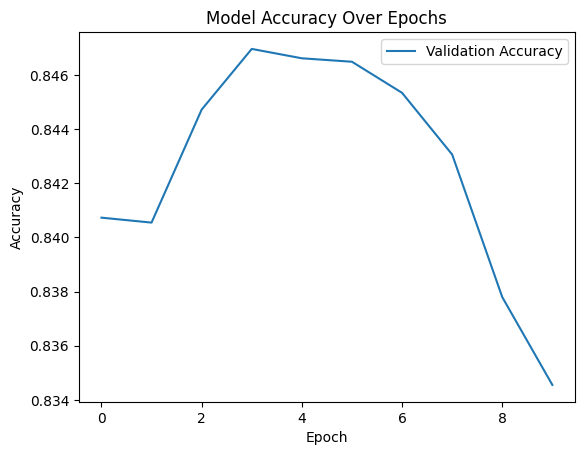

In [18]:
plt.plot(dev_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

### Predict and save results

In [19]:
reversed_ner_dict = {v: k for k, v in reformat_ner_dict.items()}
print(reversed_ner_dict)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


In [20]:
def predict_and_save(X, filename):
    Y_predicted = []
    for i in tqdm(range(len(X))):
        batch_tokens = X[i].unsqueeze(0)
        Y_batch_pred_weights = lstm(batch_tokens).squeeze(0)
        Y_batch_pred = torch.argmax(Y_batch_pred_weights, 1)
        Y_processed_pred = " ".join(reversed_ner_dict[item] for item in Y_batch_pred.numpy()[1:-1])
        Y_predicted.append(Y_processed_pred)
    Y_predicted_df = pd.DataFrame(Y_predicted, columns=['predicted_label'])
    Y_predicted_df.to_csv(filename, sep='\t', index=False, header=None)

In [21]:
dev_predicted = predict_and_save(dev_X, dev_predicted_path)
test_predicted = predict_and_save(test_X, test_predicted_path)

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]